# 1D PRF estimation of 2DeteCT data set

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Load data

In [2]:
import os
from tifffile import tifffile

DIR = "data/2detect"

def load_sinograms(slice_range: range, mode: int) -> np.ndarray:
    """
    Load sinogram.tif files from specified slice range and mode number.

    Args:
        slice_range: Range of slice numbers to load
        mode: Mode number to load

    Returns:
        numpy array containing all sinograms stacked along first dimension
    """
    sinograms = []
    for slice_num in slice_range:
        pattern = f"{DIR}/slice{slice_num:05d}/mode{mode}/sinogram.tif"
        if os.path.exists(pattern):
            img = tifffile.imread(pattern)
            sinograms.append(img)

    if not sinograms:
        raise FileNotFoundError(
            f"No sinogram files found for slice range {slice_range} and mode {mode}")

    return np.stack(sinograms).astype(np.float64)

In [3]:
try:
    del data
except NameError:
    pass

data = load_sinograms(range(4200, 4500), 3)
print(data.shape)

(300, 3601, 1912)


To estimate the PRF, a static part of the data is required. Here, a small
part of the sinogram is used in which there is no motion due to rotation.

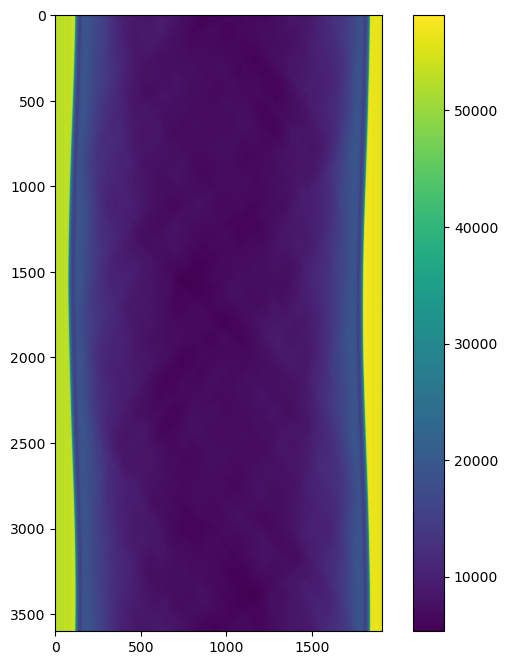

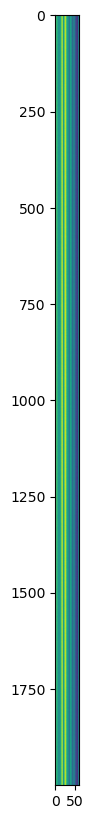

In [4]:
# Only regions without fluctuating signal can be used.
plt.figure(figsize=(8, 8))
plt.imshow(np.mean(data, axis=0))
plt.colorbar()
plt.show()

# Select a region that is not affected by signal.
estimation_region = (slice(1000, 3000), slice(1850, 1950))
prf_estimation_data = data[:, estimation_region[0], estimation_region[1]]

plt.figure(figsize=(10, 10))
plt.imshow(np.mean(prf_estimation_data, axis=0))
plt.show()

## 2. Estimate the PRF

(Images, Rows, Columns) = (300, 3601, 1912)


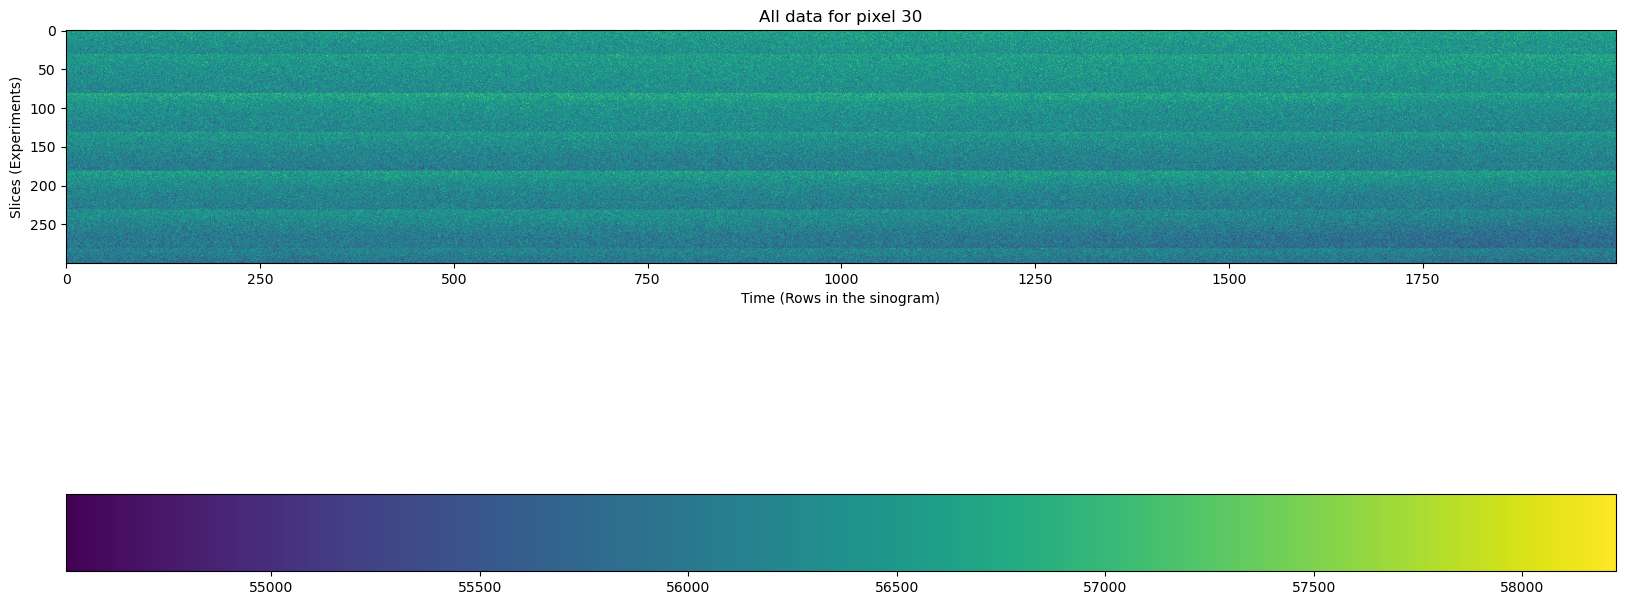

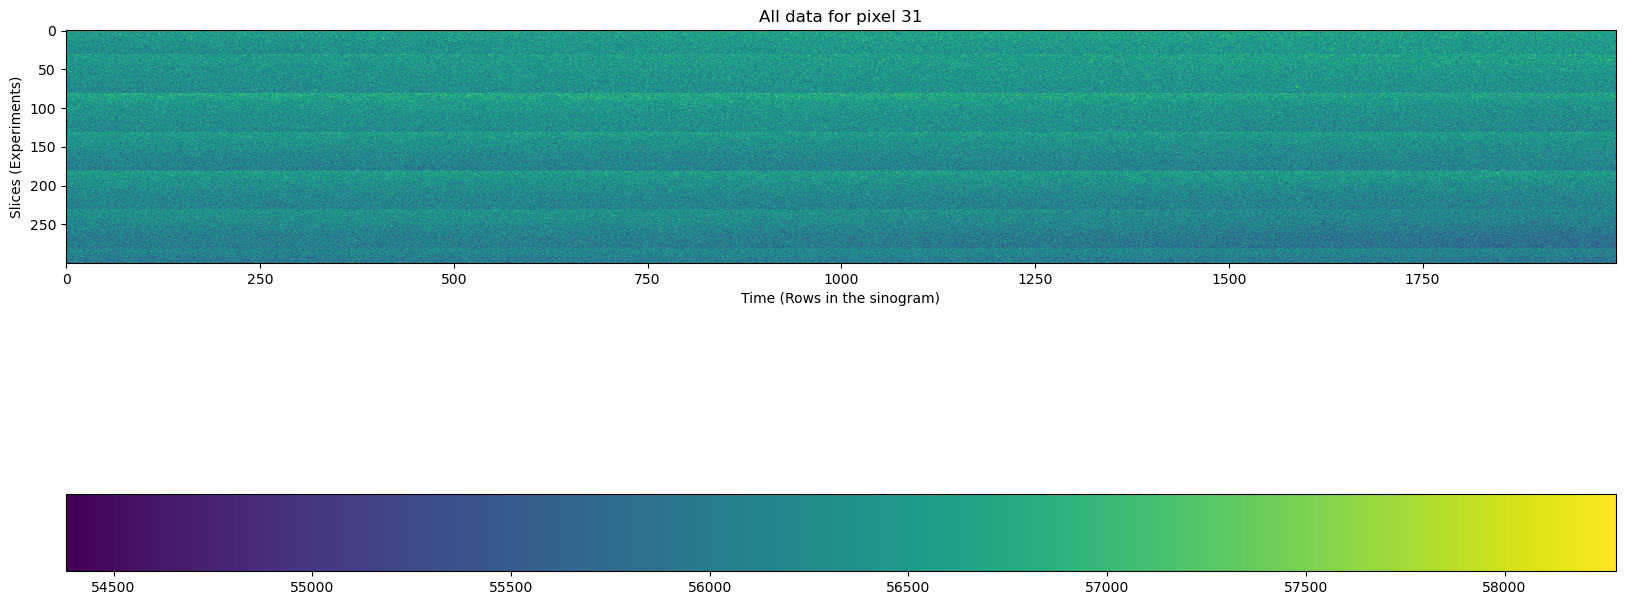

In [10]:
print(f"(Images, Rows, Columns) = {data.shape}")
plt.figure(figsize=(20, 20))
plt.title("All data for pixel 30")
plt.ylabel("Slices (Experiments)")
plt.xlabel("Time (Rows in the sinogram)")
plt.imshow(prf_estimation_data[:, :, 30])
plt.colorbar(orientation='horizontal')
plt.show()

plt.figure(figsize=(20, 20))
plt.title("All data for pixel 31")
plt.ylabel("Slices (Experiments)")
plt.xlabel("Time (Rows in the sinogram)")
plt.imshow(prf_estimation_data[:, :, 31])
plt.colorbar(orientation='horizontal')
plt.show()

# The image shows that different acquisitions use different tube strengths,
# the rows in this image. Within one acquisition, the intensity seems
# to be stable.

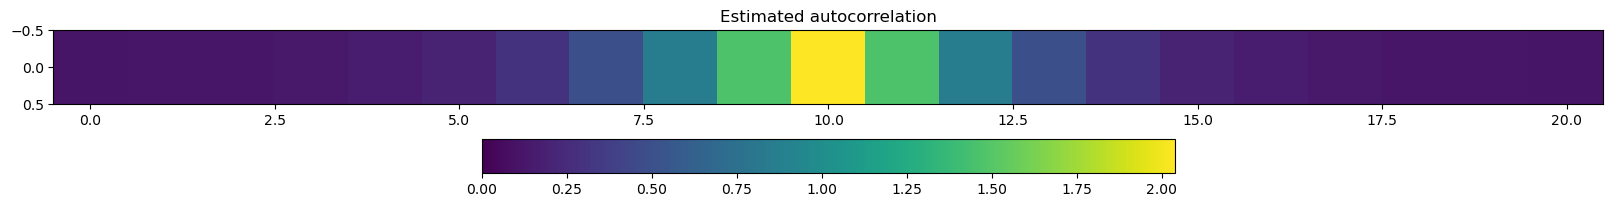

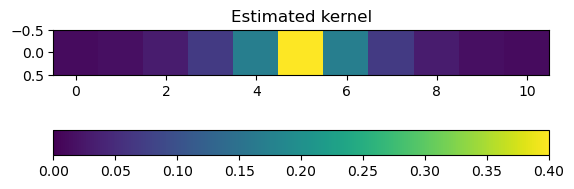

In [6]:
from scintillatordecorrelator import solve_kernel

def estimate_autocorrelation(
    data,
    out_len=5,
):
    # stabilize the noise, i.e., divide by its variance
    # for poisson noise, the variance equals the mean
    WD = np.copy(data)
    for p in range(data.shape[2]):
        for s in range(data.shape[0]):
            V = np.mean(data[s, :, p])
            WD[s, :, p] = np.divide(
                data[s, :, p] - V, np.sqrt(V), where=V != 0)

    # now, all slices and sinogram rows have the same variance
    # so we concat those
    WD = np.concatenate(WD, axis=0)

    # let's compute the 1D autocorrelation kernel
    out = np.zeros(out_len, dtype=np.float64)
    for i in range(out.shape[0]):
        i_ = i - out.shape[0] // 2
        WD_rolled = np.roll(WD, axis=1, shift=i_)
        out[i] = np.mean(WD * WD_rolled)

    return out

C_est = estimate_autocorrelation(prf_estimation_data, 21)[np.newaxis, :]

plt.figure(figsize=(20, 3))
plt.title("Estimated autocorrelation")
plt.imshow(C_est, vmin=0.0)
plt.colorbar(orientation='horizontal')
plt.show()

h_est = solve_kernel(C_est)
h_est /= np.sum(h_est)

plt.figure()
plt.title("Estimated kernel")
plt.imshow(h_est, vmin=0.0)
plt.colorbar(orientation='horizontal')
plt.show()

## 3. Deconvolve with a 1D kernel

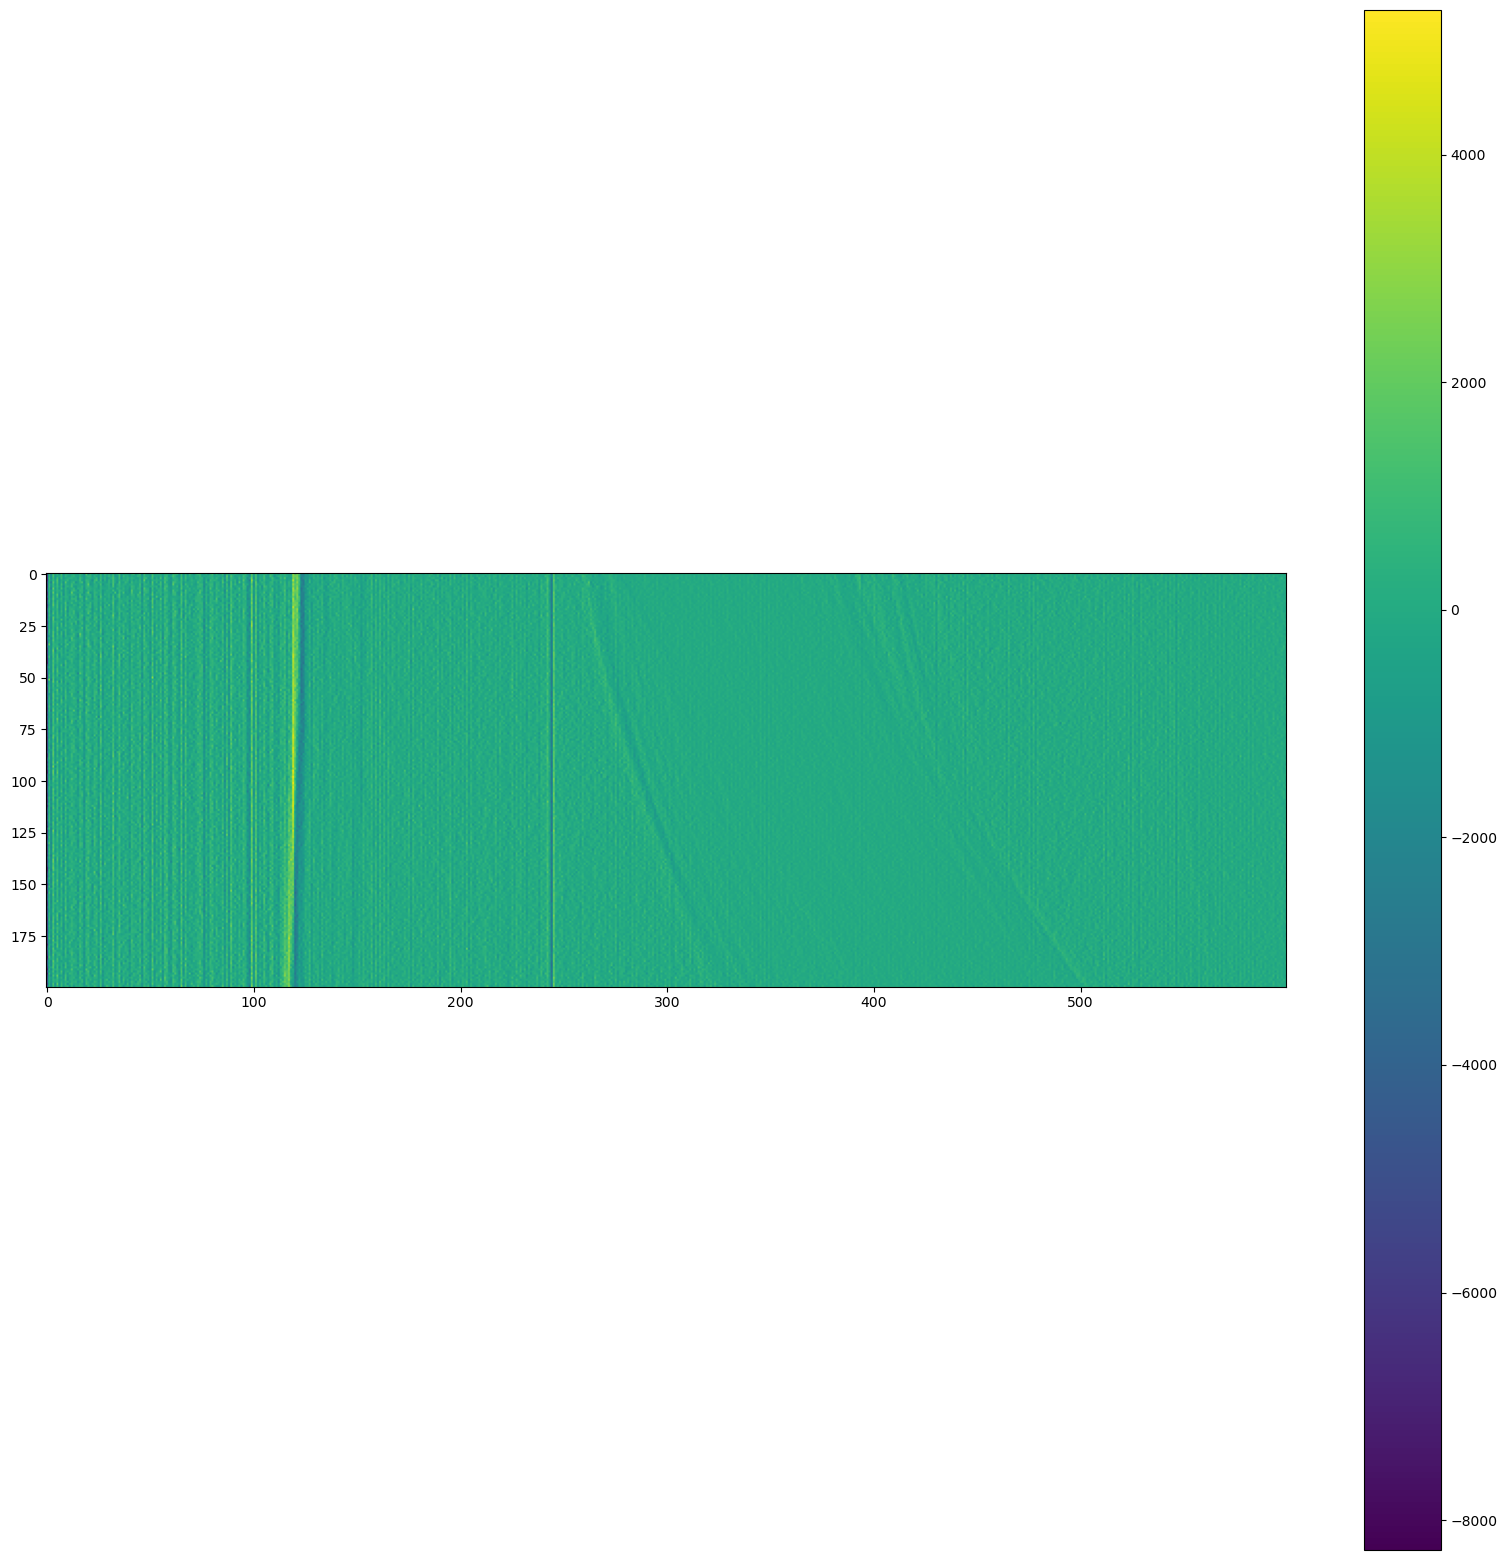

In [8]:
from scipy.fft import fft, ifft


class Deconvolve1D:
    """Deconvolve the data in Fourier space using a point-response function."""

    def __init__(self, prf):
        assert prf.ndim == 1
        self.prf = prf
        self._otf = None
        self._otf_shape = None
        self._fact = None

    def __call__(self, im):
        assert im.ndim == 1

        if self._otf_shape is None or im.shape != self._otf_shape:
            self._otf = fft(self.prf, im.shape[0])
            self._otf_shape = im.shape
            self._fact = np.conj(self._otf) / (np.abs(self._otf) ** 2)

        out = np.real(ifft(fft(im) * self._fact))
        out = np.roll(out, shift=self.prf.shape[0] // 2, axis=0)
        return out


deconvolve = Deconvolve1D(h_est[0])
deconvolved = np.empty_like(data[:1])
for i in range(deconvolved.shape[0]):
    for r in range(deconvolved.shape[1]):
        deconvolved[i, r] = deconvolve(data[i, r])

plt.figure(figsize=(20, 20))
plt.imshow((deconvolved[0] - data[0])[:200, :600])
plt.colorbar()
plt.show()


## 4. Check

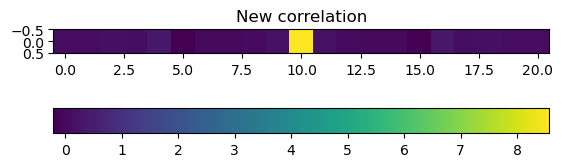

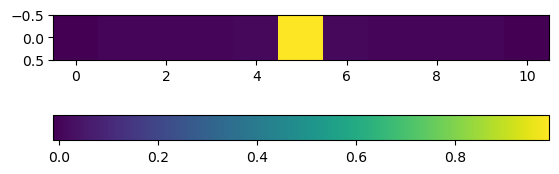

In [9]:
C2 = estimate_autocorrelation(
    deconvolved[:, estimation_region[0], estimation_region[1]],
    out_len=21
)[np.newaxis, :]

plt.figure()
plt.title("New correlation")
plt.imshow(C2)
plt.colorbar(orientation='horizontal')
plt.show()

h_deconv = solve_kernel(C2)
h_deconv /= np.sum(h_deconv)
plt.figure()
plt.imshow(h_deconv)
plt.colorbar(orientation='horizontal')
plt.show()